In [1]:
from __future__ import division
import numpy as np
import scipy.signal
import os
import scipy.io as sci_io
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import warnings
import math
import neo as ne
import scipy.signal as signal
from pathlib import Path
warnings.filterwarnings('ignore')
import quantities as pq

C:\Users\CSC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Functions Definition

In [2]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)

In [3]:
def mtem(i, j, dt):
    """
    multitaper estimation method
    Input:
    i      first time series
    j      second time series

    Output:
    fki    power spectral density i
    fkj    power spectral density j
    cij    cross-spectral density ij
    coh    coherence
    ph     phase spectrum between ij at input freq

    """
    # print('i size', i.shape)
    # print('j size', j.shape)

#     import nitime.algorithms as tsa
#     import numpy as np
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([i, j]), Fs=1 / dt, low_bias=True, adaptive=True, sides='onesided')

    # output is MxMxN matrix, extract the psd and csd
    fki = pcsd_est.diagonal().T[0]
    fkj = pcsd_est.diagonal().T[1]
    cij = pcsd_est.diagonal(+1).T.ravel()

    # using complex argument of cxy extract phase component
    ph = np.angle(cij)

    # calculate coherence using csd and psd
    coh = np.abs(cij) ** 2 / (fki * fkj)

    return f, fki, fkj, cij, ph, coh

In [4]:
def buffer_ale(x, n, p):

    import numpy as np

    a = len(np.arange(0, np.shape(x)[0] - n, p - 1))
#     a = int(np.shape(x)[0] / (n - p))
    b = (a, n)
    buf = np.zeros(b)

    a = 0;
    for i in range(0, np.shape(x)[0] - n, p - 1):
        buf[a, :] = x[i:i + n]
        a = a + 1;

    return buf

In [5]:
def cross_spectrum_mtem_vitro(signals, time):
    chs=16
    import numpy as np
    l_buf = buffer_ale(signals[0], 37, 18)
#     l_buf = buffer_ale(signals[0], 55, 28)
    n = np.shape(l_buf)
    ph_matrix = np.zeros([chs, chs, n[0]])
    Cross_spect = np.zeros([chs, chs, n[0]],dtype=complex)

    for ch1 in range(0, chs):
        for ch2 in range(0, chs):
#             print(ch1, ch2)
            s1 = signals[ch1]
            s2 = signals[ch2]
            t = time[1]
            dt = t[2] - t[1]

            s1_buf = buffer_ale(s1, 37, 18)  # windows of 0.07s with 50% overlap
            s2_buf = buffer_ale(s2, 37, 18)
            
#             s1_buf = buffer_ale(s1, 53, 27)  # windows of 0.1s with 50% overlap
#             s2_buf = buffer_ale(s2, 53, 27)
            np.shape(s1_buf)

            # cs = np.nan
            # cs= np.empty([np.shape(s1_buf)[0], 28], dtype=complex)
            cs = []
            ph_f = []
            # computing the cross-spectrum
            for i, seg in enumerate(s1_buf):
                (f, fki, fkj, csd, ph, coh) = mtem(s1_buf[i, :], s2_buf[i, :], dt)
                # (csd[i, :], f) = mlab.csd(s1_buf[i, :], s2_buf[i, :], NFFT=55, Fs=1. / dt, detrend=mlab.detrend_none,
                #                           window=mlab.window_hanning, noverlap=0, pad_to=100,
                #                           sides='default', scale_by_freq=False)
            # (f, fki, fkj, csd, ph, coh) = mtem(s1_buf[1, :], s2_buf[1, :], dt)
                if i==0:
                    cs=csd
                    ph_f=ph
                else:
                    cs = np.vstack((cs, csd))
                    ph_f=np.vstack((ph_f, ph))

            idx1=[k for k, val in enumerate(f) if val>50]
            Lfreq=f[idx1[0]]
            idx2=[k for k, val in enumerate(f) if val<110]
            Hfreq=f[idx2[-1]]

            gamma = (np.shape(cs)[0], 1)
            gamma_csd = np.zeros(gamma, dtype=complex)
            angle = np.zeros(gamma)

            for i in range(0, np.shape(cs)[0]):
                gamma_csd[i] = np.mean(cs[i, idx1[0]:idx2[-1]]) #all gamma 32:100
                angle[i] = np.angle(gamma_csd[i], deg=False)

            a = angle
            spec=gamma_csd
            # print(np.shape(a))
            # aa = np.reshape(a, (2041))
            aa = np.reshape(a, (n[0]))
            crossSpect=np.reshape(spec, (n[0]))
            # print(np.shape(aa))
            Cross_spect[ch1, ch2, :] = crossSpect
            ph_matrix[ch1, ch2, :] = aa
        # print(ph_matrix[0,0,:])

    return (f,Lfreq,Hfreq, ph_matrix, Cross_spect)

# Data Collection and Preprocessing

In [6]:
DataDir = 'C:/ALESSANDRA/PROPAGATION/PhasePropagation/DataInVitro/20171010'
# DataDir = './frontalD300'

File1 = DataDir + '/TimePeriod.mat'
mat_contents = sci_io.loadmat(File1)

DirFile = DataDir + '/20171010_02.smr'
SMRfile = ne.io.Spike2IO(DirFile)
Block = SMRfile.read()[0] # read the entire file = a Block
Seg = Block.segments[0] # child access = equivalent to trials or recordings contained in Block

AnalogSignalsArray_temp = Seg.analogsignals # array of 32 = n of channels analog signals

indice=np.arange(1,17)
chs=len(indice)
Names = [o.name for o in AnalogSignalsArray_temp]

AnalogSignalsArray = []
for j in range(len(indice)):
    if (indice[j]<10):
        i_ch = [i for i, nam in enumerate(Names) if str(indice[j]) in Names[i][-2:-1]]
        i_ch = i_ch[0]
    else:
        i_ch = [i for i, nam in enumerate(Names) if str(indice[j]).zfill(2) in Names[i][-3:-1]]
        i_ch = i_ch[0]

    AnalogSignalsArray.append(AnalogSignalsArray_temp[i_ch])
    
RawSignal=AnalogSignalsArray   

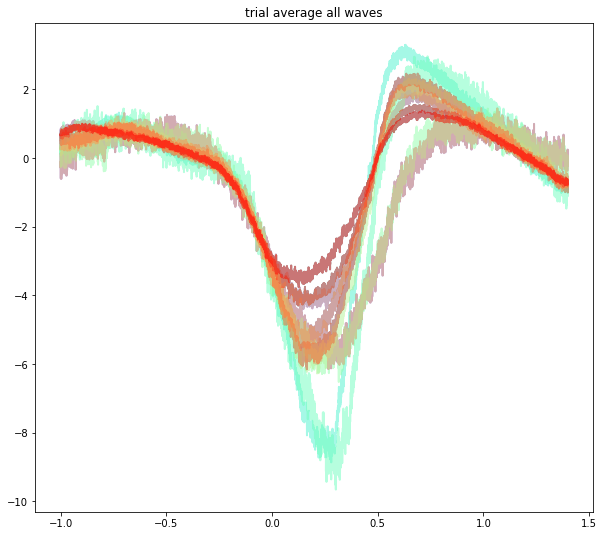

In [7]:
## trial average all waves

AnalysisDir='C:/ALESSANDRA/PROPAGATION/PhasePropagation/Analysis/20171010'
File2 = AnalysisDir + '/WaveTime.mat'
mat_contents = sci_io.loadmat(File2)
WaveTime = np.squeeze(mat_contents['WaveTime'])
Ptimes=WaveTime*pq.s;
TimeWindow = [-1, 1.4]

TimeWindow_s = TimeWindow*pq.s;

sig = RawSignal[0]
Ts = np.mean(np.diff(sig.times))
# Ts = 1/sig.sampling_rate
# print(Ts)
nSamps = int((TimeWindow_s[1]-TimeWindow_s[0])/Ts)
# print(nSamps)
tempo = np.arange(nSamps)*Ts + TimeWindow_s[0]


NormStimAvSigArray = []
for i, sig in enumerate(RawSignal):

    #     Fig = plt.figure()
    avg = np.array([])
    for et in Ptimes:
        start = et + TimeWindow_s[0]
        stop = et + TimeWindow_s[1]

        sl = sig.time_slice(start, stop)

        #         plt.plot(t, sl[:nSamps], 'k-', alpha=0.1, figure=Fig) # dibujo
        try:
            avg = np.hstack([avg, sl[:nSamps]]) if avg.size else sl[:nSamps]  # y voy acumulando
        except:
            print('Error', nSamps, et, avg.shape, sl.shape)
            break

    # Hago la media
    MeanT = np.mean(avg, axis=1)
    #     plt.plot(t, MeanT, 'r-')
    MySignal = ne.AnalogSignal(MeanT * pq.microvolt, sampling_period=Ts, t_start=tempo[0], name=sig.name + "stim_av")
    # MySignal.annotations = sig.annotations

    # Normalizo respecto al BL
    ndxBaseline = (tempo < 0).nonzero()
    MySignal_normBL = (MySignal - np.mean(MySignal.take([ndxBaseline]))) / np.std(MySignal.take([ndxBaseline]))
    MySignal_normBL.name = sig.name + "norm_stim_av"

    # Guardo señales en array
    NormStimAvSigArray.append(MySignal_normBL)

# %% Dibujo LFP_trigAv

Fig = plt.figure(figsize=(10, 9))

from matplotlib.pyplot import cm
color=cm.rainbow(np.linspace(0,1,chs))

for sig, c in zip(NormStimAvSigArray, color):
    plt.plot(tempo, sig[:nSamps], c=c, alpha=0.5, figure=Fig, linewidth=2)  # dibujo
    plt.title('trial average all waves')

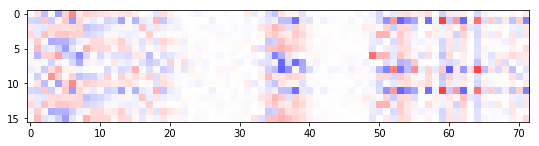

In [8]:
sg = []
ds_sg = []
ds_sg_rs = []
tm = []
ds_tm = []

downFs = 500;
for i in range(len(NormStimAvSigArray)):
    sg.append(np.array((NormStimAvSigArray[i] - np.mean(NormStimAvSigArray[i])) / np.std(NormStimAvSigArray[i]))) #raw signal
    ds_sg.append(signal.decimate(sg[i], int(RawSignal[i].sampling_rate / downFs), n=30, axis=0, zero_phase=True,
                                     ftype='fir')) #downsampled signal
    ds_sg_rs.append(ds_sg[i].reshape(len(ds_sg[i]))) #downsampled reshaped signal

    tm.append(np.array(tempo))
    ds_tm.append(signal.decimate(tm[i], int(RawSignal[i].sampling_rate / downFs), axis=0, zero_phase=True))
    
(f, Lfreq,Hfreq, Phase_mtem, cross_spect_mtem) = cross_spectrum_mtem_vitro(ds_sg_rs, ds_tm)
phm = np.empty([np.shape(Phase_mtem[0])[1], chs, chs])
for t in range(0, np.shape(Phase_mtem[0])[1]):
    for ch1 in range(0, chs):
        for ch2 in range(0, chs):
            phm[t, ch1, ch2] = (Phase_mtem[ch1, ch2, t])

ph_tri = np.empty([np.shape(Phase_mtem[0])[1], chs, chs])
ph_mean = np.empty([np.shape(Phase_mtem[0])[1], chs])

for t in range(0, np.shape(Phase_mtem[0])[1]):  # extractring the upper triangle of each matrix
    ph_tri[t, :, :] = np.triu(phm[t, :, :])
    ph_mean[t, :] = np.mean(phm[t, :, :], axis=1)


plt.figure(figsize=(9,9))
ax=plt.imshow(ph_mean.T,  cmap='bwr')
ax.set_clim(-3.14,3.14)

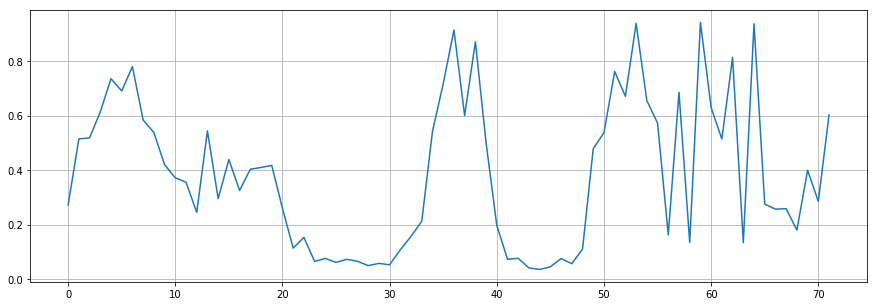

In [9]:
ph_std = np.empty(np.shape(ph_mean)[0])
for t in range(0, np.shape(ph_mean)[0]):
            ph_std[t] = np.std(ph_mean[t])

plt.figure(figsize=(15,5))
plt.grid()
ax=plt.plot(ph_std)

In [10]:
Lfreq

58.52851493961656

In [11]:
Hfreq

102.42490114432897